In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
#from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
#from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

#from tensorflow.contrib.keras.layers import Cropping2D

import tensorflow as tf

Using TensorFlow backend.


In [2]:
from keras.layers import Cropping2D, UpSampling2D
from keras.utils import np_utils

In [6]:
# Required for loss function
import math
from tensorflow.python.keras import losses

In [3]:
# Set someparameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
# Original size = 572*572
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [4]:
# Import the data
# Path for Linux
#TRAIN_PATH = '/home/ziheng/UNet/dataset_lab/train/'
#TEST_PATH = '/home/ziheng/UNet/dataset_lab/test/'

# Path for Windows
TRAIN_PATH = 'F:\\MA\\data\\dataset_lab\\train\\'
TEST_PATH = 'F:\MA\\data\\dataset_lab\\test\\'

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH + 'in/'))[2]
test_ids = next(os.walk(TEST_PATH + 'in/'))[2]

# Get and resize train images and masks
# X_train: original images
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
# Y_train: masks
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

# X_train: original images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
# Y_train: masks
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

print('Getting and resizing train images and masks ... ')

sys.stdout.flush()


for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    img = imread(TRAIN_PATH + 'in/' + id_)
    img = img[:,:,np.newaxis]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    X_train[n] = img
    #mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
    mask = imread(TRAIN_PATH + 'out-cell/' + id_.replace('.jpg', '.png'))
    #mask = mask[:,:,np.newaxis]
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = np_utils.to_categorical(mask, IMG_CHANNELS) # Generate binary masks (one hot encoding)
    Y_train[n] = mask
    
    
# Get and resize test images
#X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
#    path = TEST_PATH + id_
    img = imread(TEST_PATH + 'in/' + id_)
    img = img[:,:,np.newaxis]
#    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    X_test[n] = img
    mask = imread(TEST_PATH + 'out-cell/' + id_.replace('.jpg', '.png'))
    mask = mask[:,:,np.newaxis]
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = np_utils.to_categorical(mask, IMG_CHANNELS) # Generate binary masks (one hot encoding)
    Y_test[n] = mask
    

print('Done!')

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 476/476 [00:12<00:00, 39.40it/s]


Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 41.35it/s]


Done!


In [5]:
print(X_train.shape)
print(Y_train.shape)

(476, 128, 128, 1)
(476, 128, 128, 3)


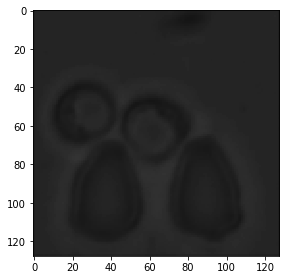

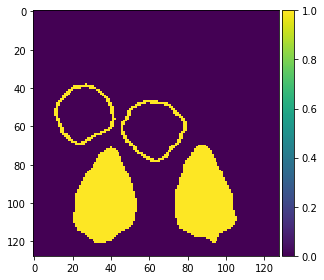

In [10]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
mask_category = 1 # Choose the mask nummer 0,1,2
imshow(np.reshape(X_train[ix], (IMG_WIDTH, IMG_HEIGHT)))
plt.show()
imshow(np.squeeze(Y_train[ix,:,:,mask_category])) 
plt.show()

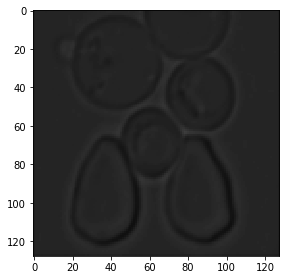

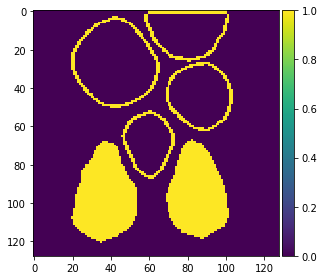

In [11]:
# Check if test data looks all right
ix = random.randint(0, len(test_ids))
mask_category = 1 # Choose the mask nummer 0,1,2
imshow(np.reshape(X_test[ix], (IMG_WIDTH, IMG_HEIGHT)))
plt.show()
imshow(np.squeeze(Y_test[ix,:,:,mask_category])) 
plt.show()

In [7]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [8]:
# Define custom metrics and loss functions
def dice_coeff(y_true,y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true , y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss (y_true, y_pred):
    loss = losses.categorical_crossentropy(y_true,y_pred)+dice_loss(y_true,y_pred)
    return loss

# The same as log_loss
def mlogloss(target, pred):
    score = 0.0
    for i in range(len(pred)):
        pp = pred[i]
        for j in range(len(pp)):
            prob = pp[j]
            if prob < 1e-15:
                prob = 1e-15
            score += target[i][j] * math.log(prob)
    return -score/len(pred)

In [9]:
# Define cropping function for UNet
def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = (target.get_shape()[2] - refer.get_shape()[2]).value
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # height, the 2nd dimension
    ch = (target.get_shape()[1] - refer.get_shape()[1]).value
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)

    return (ch1, ch2), (cw1, cw2)

In [10]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

###################

#u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = UpSampling2D(size=(2, 2))(c5)

ch, cw = get_crop_shape(c4, u6)
crop_c4 = Cropping2D(cropping=(ch,cw))(c4)

u6 = concatenate([u6, crop_c4]) # Need to crop c4 from 64 to 56
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)


#u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = UpSampling2D(size=(2, 2))(c6)

ch, cw = get_crop_shape(c3, u7)
crop_c3 = Cropping2D(cropping=(ch,cw))(c3)

u7 = concatenate([u7, crop_c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)


#u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = UpSampling2D(size=(2, 2))(c7)

ch, cw = get_crop_shape(c2, u8)
crop_c2 = Cropping2D(cropping=(ch,cw))(c2)

u8 = concatenate([u8, crop_c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)


#u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = UpSampling2D(size=(2, 2))(c8)

ch, cw = get_crop_shape(c1, u9)
crop_c1 = Cropping2D(cropping=(ch,cw))(c1)

u9 = concatenate([u9, crop_c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(IMG_CHANNELS, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=3)])
model.compile(optimizer='adam', loss = bce_dice_loss, metrics = [dice_loss, 'accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)  

                                                                 cropping2d_3[0][0]               
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 64, 64, 32)   27680       concatenate_3[0][0]              
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 64, 64, 32)   0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 64, 64, 32)   9248        dropout_8[0][0]                  
__________________________________________________________________________________________________
up_sampling2d_4 (UpSampling2D)  (None, 128, 128, 32) 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
cropping2d

In [15]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-lab-unet-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Instructions for updating:
Use tf.cast instead.
Train on 428 samples, validate on 48 samples
Epoch 1/50
428/428 [==============================] - ETA: 2:15 - loss: 2.3864 - dice_loss: 0.6742 - acc: 0.208 - ETA: 1:30 - loss: 1.9720 - dice_loss: 0.5799 - acc: 0.440 - ETA: 1:14 - loss: 1.8291 - dice_loss: 0.5438 - acc: 0.531 - ETA: 1:05 - loss: 1.7370 - dice_loss: 0.5264 - acc: 0.557 - ETA: 59s - loss: 1.6889 - dice_loss: 0.5200 - acc: 0.574 - ETA: 54s - loss: 1.6553 - dice_loss: 0.5123 - acc: 0.59 - ETA: 50s - loss: 1.6285 - dice_loss: 0.5056 - acc: 0.61 - ETA: 46s - loss: 1.6035 - dice_loss: 0.4989 - acc: 0.62 - ETA: 43s - loss: 1.5700 - dice_loss: 0.4902 - acc: 0.63 - ETA: 40s - loss: 1.5397 - dice_loss: 0.4839 - acc: 0.64 - ETA: 37s - loss: 1.5112 - dice_loss: 0.4780 - acc: 0.65 - ETA: 34s - loss: 1.4847 - dice_loss: 0.4719 - acc: 0.66 - ETA: 32s - loss: 1.4573 - dice_loss: 0.4650 - acc: 0.67 - ETA: 29s - loss: 1.4425 - dice_loss: 0.4571 - acc: 0.68 - ETA: 27s - loss: 1.4233 - dice_l

428/428 [==============================] - ETA: 1:04 - loss: 0.1646 - dice_loss: 0.0546 - acc: 0.957 - ETA: 1:02 - loss: 0.1646 - dice_loss: 0.0548 - acc: 0.957 - ETA: 1:00 - loss: 0.1576 - dice_loss: 0.0523 - acc: 0.959 - ETA: 57s - loss: 0.1648 - dice_loss: 0.0536 - acc: 0.957 - ETA: 55s - loss: 0.1655 - dice_loss: 0.0538 - acc: 0.95 - ETA: 52s - loss: 0.1740 - dice_loss: 0.0554 - acc: 0.95 - ETA: 50s - loss: 0.1767 - dice_loss: 0.0562 - acc: 0.95 - ETA: 47s - loss: 0.1773 - dice_loss: 0.0566 - acc: 0.95 - ETA: 45s - loss: 0.1802 - dice_loss: 0.0578 - acc: 0.95 - ETA: 42s - loss: 0.1784 - dice_loss: 0.0572 - acc: 0.95 - ETA: 40s - loss: 0.1732 - dice_loss: 0.0556 - acc: 0.95 - ETA: 37s - loss: 0.1764 - dice_loss: 0.0568 - acc: 0.95 - ETA: 35s - loss: 0.1787 - dice_loss: 0.0578 - acc: 0.95 - ETA: 32s - loss: 0.1753 - dice_loss: 0.0569 - acc: 0.95 - ETA: 30s - loss: 0.1773 - dice_loss: 0.0576 - acc: 0.95 - ETA: 27s - loss: 0.1777 - dice_loss: 0.0574 - acc: 0.95 - ETA: 25s - loss: 0.177

428/428 [==============================] - ETA: 1:04 - loss: 0.1326 - dice_loss: 0.0440 - acc: 0.963 - ETA: 1:02 - loss: 0.1281 - dice_loss: 0.0424 - acc: 0.965 - ETA: 1:00 - loss: 0.1316 - dice_loss: 0.0434 - acc: 0.964 - ETA: 57s - loss: 0.1288 - dice_loss: 0.0426 - acc: 0.964 - ETA: 55s - loss: 0.1295 - dice_loss: 0.0428 - acc: 0.96 - ETA: 52s - loss: 0.1321 - dice_loss: 0.0440 - acc: 0.96 - ETA: 50s - loss: 0.1303 - dice_loss: 0.0436 - acc: 0.96 - ETA: 47s - loss: 0.1286 - dice_loss: 0.0431 - acc: 0.96 - ETA: 45s - loss: 0.1251 - dice_loss: 0.0420 - acc: 0.96 - ETA: 42s - loss: 0.1258 - dice_loss: 0.0422 - acc: 0.96 - ETA: 40s - loss: 0.1260 - dice_loss: 0.0422 - acc: 0.96 - ETA: 37s - loss: 0.1255 - dice_loss: 0.0421 - acc: 0.96 - ETA: 34s - loss: 0.1258 - dice_loss: 0.0422 - acc: 0.96 - ETA: 32s - loss: 0.1262 - dice_loss: 0.0424 - acc: 0.96 - ETA: 29s - loss: 0.1279 - dice_loss: 0.0430 - acc: 0.96 - ETA: 27s - loss: 0.1287 - dice_loss: 0.0433 - acc: 0.96 - ETA: 24s - loss: 0.128

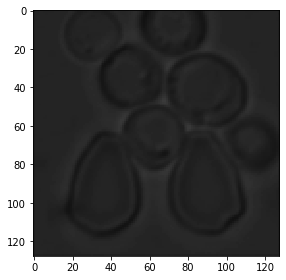

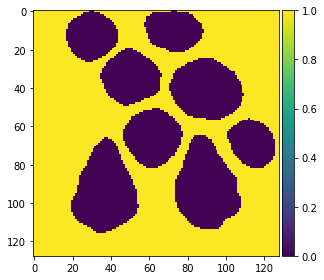

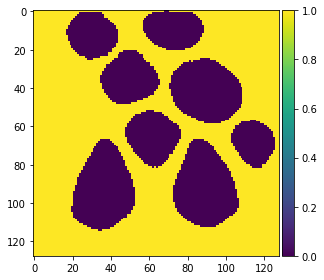

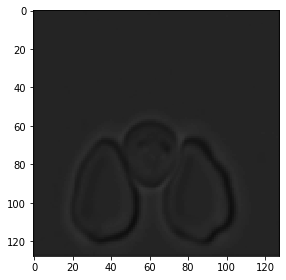

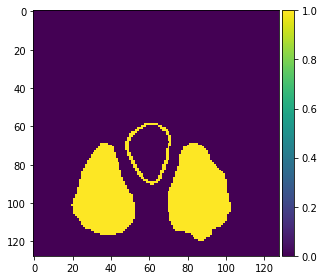

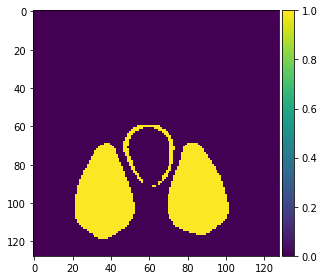